
# Fantasy EPL Project
In this project I aim to analyse data obtained from the Fantrax English Premier League fantasy football website. 

The project will continue to be updated as the football season progresses.

The goal is to continue to improve my ability to  clean and analyse data, using pandas, and improve my visualization skills.

## Data preparation

In [223]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Loading the already appended database for both positions from the previous Matchday
df_league_wide_GK = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\GK\W3GK_Appended.csv')
df_league_wide_OUT = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\OUT\W3OUT_Appended.csv')

# Loading the most recent Matchday databases for both positions (Which will have to be appended to update the database)
df_league_wide_GK_NEW = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\GK\W4GK.csv')
df_league_wide_OUT_NEW = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\OUT\W4OUT.csv')


## Appending  Databases 
The first step was to create a function that would take a csv file as a parameter and proceed to: change index, rename columns, delete unwated ones, add a 'Matchday' column, and clean 'Opponent' column values.

A function was created as this will then allow it to be used when appending the newly downloaded Matchday file.

In [224]:
def clean_league_wide(csv_file):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['Rk']).set_index('Rk') #Sets the player column as the new index (instead of numbered values)
    df.rename({'Position': 'Pos', 'Status' : 'Owner'}, axis=1, inplace=True)    
    df.drop(['% Owned', 'Roster Status','+/-'], axis=1, inplace=True)
    df['Opponent'] = df['Opponent'].apply(lambda x: x.strip('@')[0:3]) #Removes '@' and  game time(keeps only team name) 
    df['Matchday'] = 1 #Creates Matchday column and sets value to 1
    return df

The append function then takes the most recent Matchday database and feeds it to the cleaning function, correctly sets the Matchday value and then appends the old and new databases together. 

In [225]:
def append_dataframes(old_df, new_df):
    old_df = pd.read_csv(old_df)
    new_df = clean_league_wide(new_df)
    new_df['Matchday'] = (old_df['Matchday'].iloc[-1] + 1) #Sets the correct Matchday value
    old_df = old_df.dropna(subset=['Rk']).set_index('Rk') #Sets the player column as the new index (instead of numbered values)
    new_df = old_df.append(new_df) #Both databses are appended together 
    new_df.drop(['FP/G'], axis=1, inplace=True)
    return new_df

In [226]:
# Creating appended databases for both Goalkeepers and Outfielders using the function described above. 
df_appended_GK = append_dataframes(df_league_wide_GK, df_league_wide_GK_NEW)
df_appended_OUT = append_dataframes(df_league_wide_OUT, df_league_wide_OUT_NEW)

In [227]:
# Function to save newly appended databases.
def save_cleaned_files(df, name):
    df.to_csv(R'C:\\Users\\Alfonso\\Desktop\\Coding\\FantasyEPL\\'+ name + '.csv')

#save_cleaned_files(df_appended_OUT, 'W4OUT_Appended')

## Splitting databases and creating databases

In [241]:
# Creating specific databases for every position: Goalkeeper, Defender, Midfielder and Foward.
gk_df = df_appended_GK[df_appended_GK['Pos'] == 'G']
d_df = df_appended_OUT[df_appended_OUT['Pos'] == 'D']
m_df = df_appended_OUT[df_appended_OUT['Pos'] == 'M']
f_df = df_appended_OUT[df_appended_OUT['Pos'] == 'F']

In [242]:
# Columns broken up into different scoring methods(Attacking, Defending, and Maluses)
attacking_columns = ['G','KP','AT','SOT','CoS','ACNC']
defensive_columns = ['TkW','Int','CLR','AER','CS']
malus_columns = ['PKM','OG','GAO','YC','RC','DIS']

A function was then created to take a specific database and one of the scoring columns above, in order to create a new database.

In [243]:
def transform_columns(df,new_column_list):
    df = df[['Player','Pos','Team','Owner', 'Opponent', 'FPts', 'GP'] + new_column_list + ['Matchday']]
    return df

In [244]:
defensive_stats_df = transform_columns(df_appended_OUT,defensive_columns)
attacking_stats_df = transform_columns(df_appended_OUT,attacking_columns)
malus_stats_df = transform_columns(df_appended_OUT,malus_columns)

In the example below we show the bottom 10 performers of Matchday 4, along with the negative scoring columns, to have an understanding of what caused them to perform so poorly. 

In [260]:
malus_stats_df[(malus_stats_df['Matchday'] == 4)].tail(10)

,Player,Pos,Team,Owner,Opponent,FPts,GP,PKM,OG,GAO,YC,RC,DIS,Matchday
Rk,,,,,,,,,,,,,,
123,Anthony Martial,F,MUN,CIU,TOT,-2.00,1,0,0,2,0,1,3,4
124,Michael Keane,D,EVE,LEEDS,BHA,-2.75,1,0,0,2,0,0,1,4
125,Ben White,D,BHA,LEEDS,BHA,-4.25,1,0,0,4,0,0,1,4
126,Virgil van Dijk,D,LIV,nikn,LIV,-4.75,1,0,0,7,1,0,0,4
127,James Justin,D,LEI,MoM,WHU,-5.00,1,0,0,3,0,0,2,4
128,Andrew Robertson,D,LIV,LEEDS,LIV,-5.25,1,0,0,7,0,0,2,4
129,Trent Alexander-Arnold,D,LIV,KPR,LIV,-5.75,1,0,0,7,0,0,0,4
130,Luke Shaw,D,MUN,KPR,TOT,-7.75,1,0,0,6,1,0,3,4
131,Aaron Wan-Bissaka,D,MUN,MoM,TOT,-8.00,1,0,0,6,0,0,0,4


In this case we can quickly see that since defenders score -2 points when conceeding a goal (GOA), these players performed extremely poorly due to having conceeded so many goals.

## Team of the Week Creator

This next section of code sorts out players in the appended database within a specified database and creates a Team of the Week (11 best players). But keeping the following parameters: 3 Forwards, 3/4 Midfielders, 3/4 Defenders and 1 Goalkeeper. 

Most of the time the top scoring players are Forwards so the Team would just be filled with Forwards instead of an actual legal formation.

In [253]:
# In the case of the Goalkeepers its very easy as only the top scoring player has to be shown.
def create_GK_TOTW(database_GK,sorting_value,matchday):
    df=database_GK.loc[database_GK['Matchday'] == matchday].sort_values(sorting_value,ascending=False)[:1]
    return df

In [261]:
# For Outfield players a loop is used to go through all the rows and delete them as it works through the database
# leaving only a legal formation at the end
def create_OUT_TOTW(database_OUT, sorting_value,matchday):
    df=database_OUT.loc[database_OUT['Matchday'] == matchday].sort_values(sorting_value,ascending=False)
    D=0 ; M=0 ; F=0  
    for index, row in df.iterrows():
        if row['Pos'] == 'D':
            D += 1
            if D == 4 and M >= 3 or D >= 5:
                df=df.drop(index)
        elif row['Pos'] == 'M':
            M += 1
            if M == 4 and D >= 3 or M >= 5:
                df=df.drop(index)
        elif row['Pos'] == 'F':
            F += 1
            if F > 3:
                df=df.drop(index)    
    return df

In [262]:
MATCH_DAY = 4 #Variable that lets us look at different matchdays
df_TOTW_GK = create_GK_TOTW(gk_df,'FPts', MATCH_DAY )
df_TOTW_OUT = create_OUT_TOTW(df_appended_OUT,'FPts', MATCH_DAY )

Below we can see the two databases for Matchday 4

In [263]:
df_TOTW_GK

,Player,Team,Pos,Owner,Opponent,FPts,GP,CS,GA,Sv,YC,RC,PKS,PKM,TkW,DIS,G,KP,AT,Int,CLR,CoS,AER,AC,OG,SOT,Matchday
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Alex McCarthy,SOU,G,KPR,WBA,14.25,1,1,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4


In [264]:
df_TOTW_OUT 

,Player,Team,Pos,Owner,Opponent,FPts,GP,G,KP,AT,SOT,TkW,DIS,YC,RC,ACNC,Int,CLR,CoS,AER,PKM,OG,GAO,CS,Matchday
Rk,,,,,,,,,,,,,,,,,,,,,,,,,
1,Jack Grealish,AVL,M,CIU,LIV,54.50,1,2,5,3,2,3,0,0,0,0,1,1,0,1,0,0,2,0,4
2,Ollie Watkins,AVL,F,CIU,LIV,46.50,1,3,2,1,4,0,3,0,0,0,1,0,1,2,0,0,2,0,4
3,Ben Chilwell,CHE,D,MoM,CRY,39.25,1,1,3,1,1,0,0,0,0,3,3,1,0,2,0,0,0,1,4
4,Son Heung-Min,TOT,F,CIU,TOT,37.50,1,2,5,1,2,0,2,0,0,0,0,0,0,1,0,0,1,0,4
5,Harry Kane,TOT,F,MoM,TOT,36.50,1,2,3,1,3,0,1,0,0,0,1,0,0,0,0,0,1,0,4
6,James Rodriguez,EVE,M,Cavleti,BHA,36.50,1,2,2,1,2,2,3,0,0,1,1,0,2,0,0,0,1,0,4
9,Allan Saint-Maximin,NEW,M,Cavleti,BUR,27.50,1,1,3,1,1,0,1,0,0,1,0,0,4,0,0,0,1,0,4
10,John McGinn,AVL,M,MoM,LIV,26.00,1,1,1,1,1,1,2,0,0,0,3,2,4,0,0,0,2,0,4
16,Yerry Mina,EVE,D,Cavleti,BHA,18.00,1,1,0,0,1,1,0,0,0,0,4,4,0,4,0,0,2,0,4


# Data Visualization

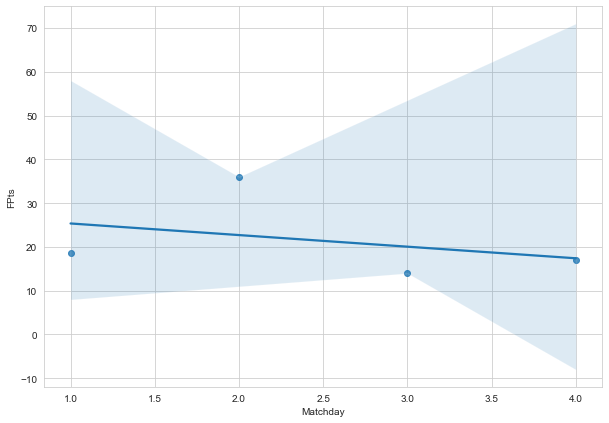

In [284]:
# Linear regression graph with scatter plots showing the performance of a specific player across a season.
df_Player_Analysis = df_appended_OUT[(df_appended_OUT['Player'] == 'Dominic Calvert-Lewin')] 

fig, ax = plt.subplots(figsize=(10,7))
plot = sns.regplot(x= df_Player_Analysis['Matchday'] , y= df_Player_Analysis['FPts'], scatter=True)

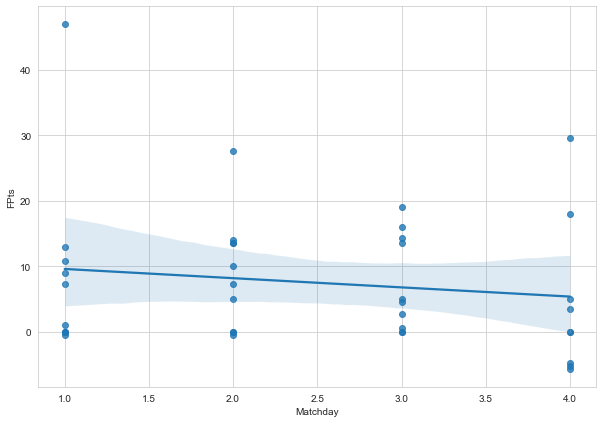

In [283]:
# Linear regression graph with scatter plots (Points scored by individual players on the team) tracking the 
# the performance of one Team in the Premier League across different matchdays.
df_Team_Analysis = df_appended_OUT[(df_appended_OUT['Team'] == 'LIV')] #Liverpool being analysed below

fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(x= df_Team_Analysis['Matchday'] , y= df_Team_Analysis['FPts'], scatter=True)

(0.75, 4.25)

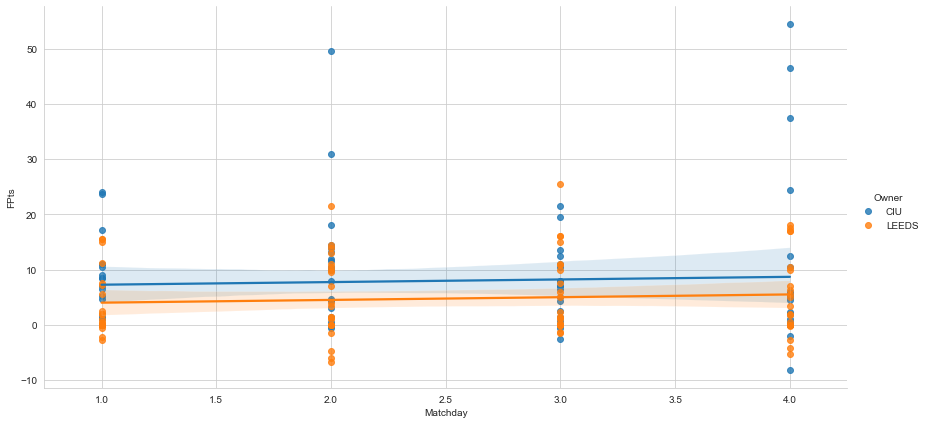

In [288]:
# Using two line graphs to compare the performance of two Owners' teams across the season.
# the performance of one Team in the Premier League across different matchdays.
df_team_comparison=df_appended_OUT.loc[(df_appended_OUT['Owner'] == 'LEEDS') | (df_appended_OUT['Owner'] == 'CIU')]

sns.lmplot(x= 'Matchday', y= 'FPts',hue= 'Owner',data=df_team_comparison, height=6, aspect=2) 
plt.xlim(0.75, df_appended_OUT['Matchday'].iloc[-1]+0.25)

(0.75, 5)

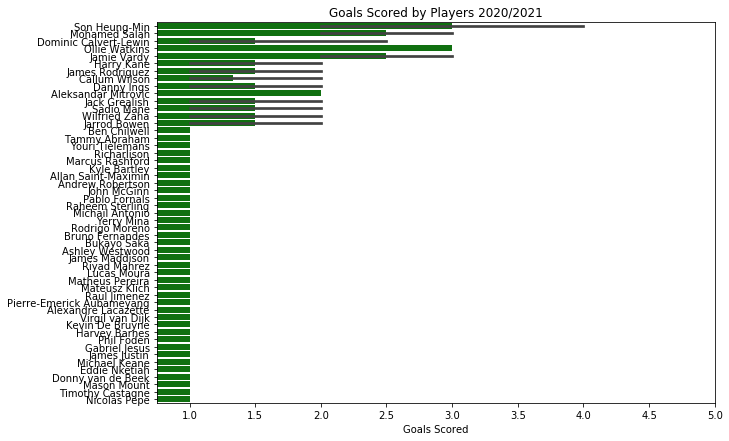

In [168]:
df_Goals=df_appended_OUT[(df_appended_OUT['G'] >= 1)]

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
plot=sns.barplot(
    x='G', 
    y='Player',
    data=df_Goals.sort_values('G',
    ascending=False),
    color="g",)
plt.xlabel("Goals Scored"),
plt.ylabel("")
plt.title("Goals Scored by Players 2020/2021")
plt.xlim(0.75, df_appended_OUT['G'].max()+1)